In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from analytical import *
from cost import *
from params import *
from utils import *

% LaTeX macros...
$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\R}{\mathbb{R}}$
$\renewcommand{\P}{\mathcal{P}}$
$\newcommand{\U}{\mathcal{U}}$
$\newcommand{\T}{\mathrm{T}}$
$\newcommand{\tf}{\mathbf}$
$\newcommand{\ts}{\mathtt}$
$\newcommand{\dt}[1]{\dot{#1}}$
$\newcommand{\mat}{\mathrm}$
$\newcommand{\bigO}{\mathcal{O}}$
$\newcommand{\dd}{\, \mathrm{d}}$
$\newcommand{\dt}[1]{\dot{#1}}$
$\newcommand{\intset}[2]{\{#1, ..., #2\}}$

Notations:
- Scalars and vectors are denoted in lower case letters: $x$, $y$;
- Scalar- and vector-valued functions of time are denoted in bold lower case letters: $\tf x$, $\tf y$;
- Time series (and vectors interpreted as such) are denoted in teletype font: $\ts x$;
- $\dt{\tf x}$ is the derivative in time of $\tf x$;
- If $x$ is a column vector, $x^T$ is the corresponding row vector;
- Matrices are denoted by upright capital letters: $\mat A$;
- $\mat A^\T$ is the transpose of $\mat A$. 

# Problem presentation and parameterization

In this notebook we consider a very simple linear-quadratic problem.

We study the movement of a cart assimilated to a mechanical point of mass $m > 0$ that moves along an axis. Its position is denoted by $x \in \Omega = \R$. The cart starts from position $x_0 \in \Omega_0 = [-1, 0]$ and velocity $0$, and we want to bring the cart to position $0$ and keep it there as long as possible over a horizon $T$, with minimal control $u \in \R$. The control is here interpreted as a direct control of the velocity of the cart (and not of its acceleration).

In what follows we take $m=1$.

In [2]:
print("Time horizon:", T)

Time horizon: 1


## Formulation as a continuous control problem

We denote by:
- $\tf x: [0, T] \to \Omega$ the trajectory of the cart, that is its position at every time $t$;
- $\tf u: [0, T] \to U$, where $U=\R$, the control over time $t$. In what follows, we'll look for $u \in \U$ where $\U = L^1([0, T], U)$.

The dynamic of the system is given by the Cauchy problem:
$$
    \begin{cases}
        \dt{\tf x}(t) = \tf u(t) & \forall t \in [0, T],\\
        \tf x(0) = x_0,
    \end{cases}
$$
where $x_0 \in [-1, 0]$.

Our choice of $\U$ ensures by Cauchy-Lipschitz theorem that this problem has a unique solution $\tf x_\tf u \in AC([0, T], \R)$.

We then want to minimize:
$$
    \min_{\tf u \in \U} J(\tf u),
$$
where
$$
    J(\tf u) = \int_0^T \big( \lambda \tf x(t)^2 + \tf u(t)^2 \big) \dd t
$$
with $\lambda > 0$.

In [3]:
print("Target trajectory penalization:", LAMBDA) 

Target trajectory penalization: 10


This problem can be rewritten as a Linear Quadratic Regulator (LQR):
$$
    \min_{\tf u \in \U} J(\tf u),
$$
where
$$
    J(\tf u) = \int_0^\T (\tf x_u^\T \mat Q \tf x_u + \tf u^\T \mat R\tf u) \dd t + \tf x_\tf u(T)^\T \mat D \tf x_\tf u(T)
$$
and
$$
    \begin{cases}
        \dt{\tf x}_\tf u(t) = \mat A \tf x(t) + \mat B \tf u(t) & \forall t \in [0, T],\\
        \tf x(0) = x_0,
    \end{cases}
$$
where $\mat A=0$, $\mat B=1$, $\mat Q=\lambda$, $\mat R=1$ and $\mat D=0$

Note that the problem is continuous both in time and space, so we will have to discretize it in time and space to apply vanilla Q-learning.

# Continuous control implementation

Using the adjoint state $p$, we can get an analytical solution for the continuous control problem. Indeed, the control is optimal if and only if:
$$
    \tf u(t) = -\mat R^{-1} \mat B \tf p(t) = -\tf p(t) \qquad \forall t \in [0, T],
$$
where
$$
\begin{cases}
    \dt{\tf p}(t) = -\mat A \tf p(t) - \mat Q \tf x(t) = -\lambda \tf x(t) & \forall t \in [0, T],\\
    \tf p(T) = 0
\end{cases}
$$
Hence:
$$
\begin{cases}
    \dt{\tf x} = \tf u = \tf p,\\
    \dt{\tf p} = -\lambda \tf x.
\end{cases}
$$
That is, for $\tf y^\T=(\tf x\ \tf p)$,
$$
    \dt{\tf y} = \mat Z \tf y
$$
where
$$
    \mat Z =\begin{pmatrix}
        0 & -1\\
        -\lambda & 0
    \end{pmatrix}.
$$
We thus know that:
$$
    \tf y(t) = \begin{pmatrix} x_0 \\ \tf p(0) \end{pmatrix} e^{t \mat Z}.
$$
We compute by hand:
$$
    e^\mat Z =\begin{pmatrix}
        \cosh(\sqrt{\lambda}) & -\frac{1}{\sqrt{\lambda}}\sinh(\sqrt{\lambda})\\
        -\sqrt{\lambda}\sinh(\sqrt{\lambda}) & \cosh(\sqrt{\lambda})
    \end{pmatrix}.
$$
and deduce:
$$
\begin{cases}
    \tf x(t) = x_0\cosh(\sqrt{\lambda}t) - \frac{\tf p(0)}{\sqrt{\lambda}}\sinh(\sqrt{\lambda}t),\\
    \tf p(t) = -\sqrt{\lambda}x_0\sinh(\sqrt{\lambda}t) + \tf p(0)\cosh(\sqrt{\lambda}t).
\end{cases}
$$
Lastly, using the fact that $\tf p(T)=0$, we compute:
$$
\boxed{
\begin{cases}
    \tf x(t) = \frac{x_0}{\cosh(\sqrt{\lambda}T)} \cosh\big(\sqrt{\lambda}(T-t)\big)\\
    \tf u(t) = - \tf p(t) = -\frac{\sqrt{\lambda}x_0}{\cosh(\sqrt{\lambda}T)}\sinh\big(\sqrt{\lambda}(T-t)\big)
\end{cases} \qquad \forall t \in [0, T].
}
$$

## Visualization of the solution

In [5]:
x0 = -1
gt_x, gt_u = ground_truth_sample(x0)
print("Position at final time:", gt_x[-1])

Position at final time: -0.08450702270392474


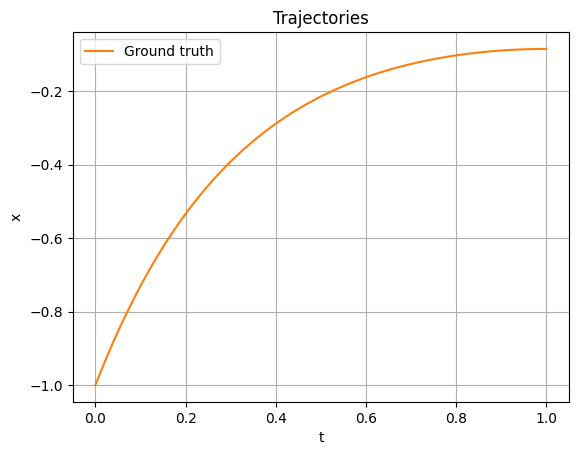

In [6]:
plot_trajectory(gt_x=gt_x, crop_y=False)

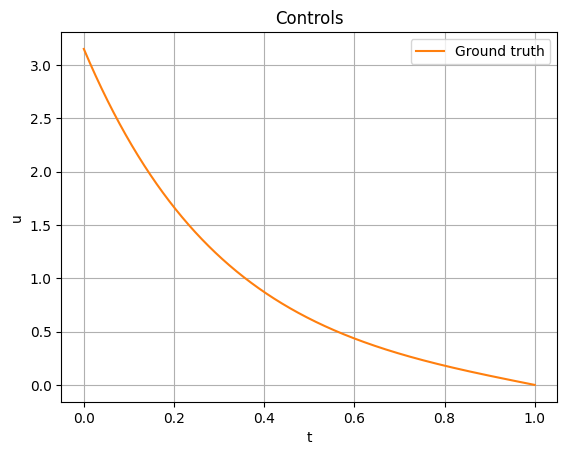

In [7]:
plot_control(gt_u=gt_u)

In [8]:
# Approximation of the optimal cost
cost(*ground_truth_sample(x0))

3.1509343154717495

# Reinforcement Learning implementation

To make the problem solvable by RL using Q-learning methods
, we need to discretize it in time. Let $N \in \N^*$ be the discretization resolution and $\Delta t = \frac{T}{N} = \frac{1}{N}$ the time step. Let $\forall n \in \intset{0}{N}, \ t_n = n \Delta t, \ u_n = u(t_n)$ and $x_n = x(t_n)$. We also denote by $\ts x$ and $\ts u$ the vectors $(x_0, ..., x_N)^\T$ and $(u_0, ..., u_{N-1})^\T$ .

With this discretization, we now _choose_ to restrict the search of a control $\tf u$ in a subset $\U_{\Delta t} \subset \U$, namely:
$$
    \U_{\Delta t} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N-1}, u_n \in U \right\}.
$$
This means that we can only hope to get a _suboptimal_ solution for the continuous control problem.

Moreover, we observe that for any $\tf u \in \U_{\Delta t}$ and any $n \in \intset{0}{N-1}$:
$$
    x_{n+1} = x_n + \int_{t_n}^{t_{n+1}} \dt{\tf x}(t) \dd t = x_n + \int_{t_n}^{t_{n+1}} u_n \dd t = x_n + \Delta t\,u_n,
$$
which encourages us to choose the following simulator that we will call every $\Delta t$ time step to compute the trajectory on points $x_n, \ n \in \intset{1}{N}$:
$$
    \begin{array}{llll}
         \P: &  \Omega \times U & \to      & \Omega \\
             & (x, u)            & \mapsto & x + \Delta t\, u.
    \end{array}
$$
Note that this simulator is equivalent to using an _Euler explicit_ integration scheme but it computes the _exact_ value of $x_{n+1}$. This is because in our dynamics, $\mat A=0$ and because we chose a convenient shape for $\tf u$. For harder problems, we might want to use a numerical integration method which won't give the exact trajectory.

In this framing, the cost function _rewrites_:
$$
    J(\ts u) = \lambda \int_0^T \tf x(t)^2 \dd t + \Delta t \sum_{n=0}^{N-1} u_n^2 = \lambda \sum_{n=0}^{N-1} \int_{t_n}^{t_{n+1}} \tf x(t)^2 \dd t + \Delta t \sum_{n=0}^{N-1} u_n^2
$$
Now, $\forall n \in \intset{0}{N-1}, \ \forall t \in [t_n, t_{n+1}], \ \tf x(t) = x_n + (t-t_n)u_n$, so:
$$
    \int_{t_n}^{t_{n+1}} \tf x(t)^2 \dd t = \Delta t x_n^2 + {\Delta t}^2 x_n u_n + \frac{{\Delta t}^3}{3} u_n^2
$$
So,
$$
    J(\ts u) = \lambda \sum_{n=0}^{N-1} \Big( \Delta t x_n^2 + {\Delta t}^2 x_n u_n + \frac{{\Delta t}^3}{3} u_n^2 \Big) + \Delta t \sum_{n=0}^{N-1} u_n^2
$$
Note that here, the cost is still exactly equal to the one of the initial problem, because integrating $\tf x^2$ on each segment $[t_n, t_{n+1}]$ is not difficult. Therefore, we will be able to design very accurate reward functions, that give a lot of information on the underlying model.

In many cases, it may not be easy to use time-discrete observations of the state to design reward function exactly matching the cost function of the original optimal problem.

In [9]:
print("N:", N)
print("DT", DT)

N: 20
DT 0.05


## Discrete Q-learning

### Discretization

In a first RL approach, let's use the $Q$-learning algorithm with an $\varepsilon$-policy, implementing $Q$ as a matrix such that $Q_{s, a}$ is an approximation of the $Q$ function in state $s$ and action $a$.

However, this implementation requires further discretizing the problem, both in state and action spaces.
Therefore, we arbitrarily restrain $U$ to $\tilde{U} = [U_l, U_r]$ (with $U_l \in \mathbb{Z}^-$ and $U_r \in \N$) and $\U$ to $\tilde{\U} = L^1\big( [0, T],  \tilde{U} \big)$. We also restrain $\Omega$ to $\tilde{\Omega} = [-\Omega_l, \Omega_r] = [-1 + U_l\,T, U_r\,T]$ which is a natural choice because it is the union of the sets $E(x_0, T) = \{x_1 \in \R | \exists u \in \tilde{\U}, \ x_u(T) = x_1 \} $ of reachable positions from $x_0$ and $T$, for $x_0 \in [-1, 0]$.

Let's introduce $N_\Omega$ and $N_U$ the discretization resolutions for $\tilde{\Omega}$ and $\tilde{U}$, and $\Delta x = \frac{1}{N_{\Omega}}$ and $\Delta u = \frac{1}{N_U}$. For consistency, if we want the minimal gap between 2 states to coincide with the minimal possible step taken by the system, we should choose $N_\Omega$ such that $\Delta x = \Delta u\,\Delta t$, that is $N_\Omega = \frac{N_U}{\Delta t}$.

We now look for $u$ in
$$
    \tilde{\U}_{\Delta t, \Delta u} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N-1}, u_n \in \tilde{U}_{\Delta u} \right\},
$$
where
$$
    \tilde{U}_{\Delta u} = \{U_l, U_l + \Delta u, ..., U_r\}
$$
(so $|\tilde{U}_{\Delta u}| = (U_r - U_l)N_U + 1$).

Furthermore, for a correctly rounded $x_0$, with our choice of $\tilde{\U}_{\Delta t, \Delta u}$, the $x_n, \ n \in \intset{0}{N}$, will be confined in:
$$
    \tilde{\Omega}_{\Delta x} = \{ \Omega_l, \Omega_l + \Delta u\,\Delta t, ..., \Omega_r \}
$$
(so $|\tilde{\Omega}_{\Delta x}| = (\Omega_r - \Omega_l)N_\Omega + 1$), which is consistent with our choice of $\Delta x$.

The minimization problem is now:
$$
    \min_{(u_n)_{n\in \{0, ..., N-1\}} \in (U_{\Delta u})^N} \lambda \sum_{n=0}^{N-1} \Big( \Delta t x_n^2 + {\Delta t}^2 x_n u_n + \frac{{\Delta t}^3}{3} u_n^2 \Big)+ \Delta t \sum_{n=0}^{N-1} u_n^2
$$

We are not done yet, because in practice $x$ and $u$ need to be integers if we want to interprete them as indices for $Q_{x, u}$ easily. The states and controls manipulated by $Q$ and the policy will live in:
$$
    \tilde{\Omega}_{\Delta x}^{RL} = \{ 0, \Delta x, ..., (\Omega_r - \Omega_l) N_\Omega \Delta x \}
$$
and
$$
    \tilde{U}_{\Delta u}^{RL} = \{ 0, \Delta u, ..., (U_r - U_l) N_U \Delta u \}
$$
respectively. We define functions to easily switch from one representation to another:
- $\phi_{u \to u^{Rl}}$ to go from $\tilde{U}_{\Delta u}$ to $\tilde{U}_{\Delta u}^{RL}$;
- $\phi_{x \to x^{RL}}$ to go from $\tilde{\Omega}_{\Delta x}$ to $\tilde{\Omega}_{\Delta x}^{RL}$

and their inverses $\phi_{u^{Rl} \to u}$ and $\phi_{x^{RL} \to x}$

In [10]:
print("[U_l, U_r]:", f"[{Ul}, {Ur}]")
print("N_U:", N_U)
print("[OMEGA_l, OMEGA_r]:", f"[{OMEGAl}, {OMEGAr}]")
print("N_OMEGA:", N_OMEGA)

[U_l, U_r]: [-8, 8]
N_U: 5
[OMEGA_l, OMEGA_r]: [-9, 8]
N_OMEGA: 100


### Formulation

We have the following formulation in RL:
- state space: $S = \tilde{\Omega}_{\Delta x}^{RL}$; a state is $s \in S$ and is the position of the cart $\tf x$ at a given time step;
- action space: $A = \tilde{U}_{\Delta u}^{RL} $; an action is $a \in A$ and is a representation of the control $\tf u$ at a given time step;
- transition function: $f: S \times A \to S$ defined by $f(s, a) = \phi_{x \to x^{RL}}\Big(\P\big(\phi_{x^{RL} \to x}(s), \phi_{u^{RL} \to u}(a)\big)\Big)$
- running reward function: $\forall n \in \intset{0}{N-1}, \ r_n(s, a) \equiv r(s, a) = -\lambda \Big( \Delta t |\phi_{x^{RL} \to x}(s)|^2 + {\Delta t}^2 \phi_{x^{RL} \to x}(s)\phi_{u^{RL} \to u}(a) + \frac{{\Delta t}^3}{3} |\phi_{u^{RL} \to u}(a)|^2 \Big) - \Delta t |\phi_{u^{RL} \to u}(a)|^2$
- final reward function: $r_N(s) = 0$

Note that since the problem is of finite time-horizon, the $Q$ function and the policy $\pi$ will also depend on time.

### Implementation

To make this translation from continuous optimal control framing to RL framing, we leave the code for the RL solver apparent in the notebook.

In [11]:
# Q-learning algorithm parameters
LEARNING_RATE = 0.5  # Default learning rate
EPSILON = 0.1  # Default epsilon for the u-epsilon policy
N_EPSISODES = 100  # Default number of episodes for training

In [12]:
# Define rewards
def  running_reward(sn, an):
    """ Takes state and action (s_n, a_n) and returns the associated running reward. """
    xn = x_RL_to_x(sn)
    un = u_RL_to_u(an)
    return -LAMBDA*(DT*xn**2 + DT**2*xn*un + (DT**3)/3*un**2) - DT*un**2

def  final_reward(sN):
    """ Takes state and action (s_N) and returns the associated final reward. """
    return 0

In [13]:
# Define a transition function that takes a state and action as inputs and outputs the next state.
def  transition(sn, an):
    """ Takes state and action (s_n, a_n) and return a new state s_{n+1} and reward r_n. """
    return (x_to_x_RL(x_RL_to_x(sn) + DT*u_RL_to_u(an)), running_reward(sn, an))

# Use this transition function to derive a simulator that rolls out a given policy from a given initial state and outputs the resulting trajectory (state and control) and cost
def simulator(x0, policy):
    """ Run a simulation of the system between times 0 and T. """
    x = np.zeros(N+1)
    u = np.zeros(N+1)
    r = np.zeros(N+1)
    x[0] = x0
    for n in range(N):
        sn = x_to_x_RL(x[n])
        an = policy(n, sn)
        u[n] = u_RL_to_u(an)
        snew, r[n] = transition(sn, an)
        x[n+1] = x_RL_to_x(snew)
    r[-1] = final_reward(x[-1])
    u[-1] = 0  # u is given a shape N+1 to have matching shapes for x and u, which makes comparing with ground truth easier.
    return (x, u, r)

In [14]:
@dataclass
class TrainingHistory:
    """ Stores data on the training of an agent; used to plot learning curves. """
    evaluate_every: int  # Number of training episodes between each evaluation of the agent
    nb_episodes_for_evaluation: int  # The number of episodes run during one evaluation
    avg_cost: list  # One element of this list is the average final cost computed over the episodes of one evaluation.
    cumulative_rewards: list  # One element of this list is another list containing the cumulative rewards for all episodes of a given evaluation;
                              # in other words one element of this inner list is the sum of rewards over all time steps of a given run.

        
class Agent:
    """ A Q-learning agent, composed of an array Q and methods to train or exploit it. """
    
    def __init__(self, lr = LEARNING_RATE, eps = EPSILON, evaluate_every=500, nb_episodes_for_evaluation=100):
        self.Q = -max(LAMBDA, 1) * np.random.rand(N, (OMEGAr - OMEGAl)*N_OMEGA+1, (Ur - Ul)*N_U+1)  # Initialize Q randomly in an order of magnitude of the running cost
        self.lr = lr  # Learning rate for an update of Q in the Q-learning algorithm
        self.eps = eps  # Epsilon parameter for the epsilon-policy used during training
        self.training_history = TrainingHistory(evaluate_every, nb_episodes_for_evaluation, [], [])   
        avg_cost, cumulative_rewards = self.evaluate()
        self.training_history.avg_cost.append(avg_cost)
        self.training_history.cumulative_rewards.append(cumulative_rewards)
    
    def policy(self, n, s):
        """ Greedy policy associated to the array Q of the agent. """
        return np.argmax(self.Q[n, s, :])
    
    def Q_learn(self, n_episodes = 100000):
        """ Train the agent for n_episodes episodes using the Q-learning algorithm from Watkins, 1989. """
        evaluate_every = self.training_history.evaluate_every
        average_cost_over_episodes = []
        cumulative_rewards_over_episodes = []
        for k in range(n_episodes):
            x0 = -np.random.random()
            s = x_to_x_RL(x0)
            for n in range(N):
                if np.random.random() < self.eps:
                    eps_policy = lambda n, s: np.random.randint((Ur - Ul)*N_U+1)
                else:
                    eps_policy = self.policy
                a = eps_policy(n, s)
                s_new, r = transition(s, a)
                if n == N-1:
                    self.Q[n, s, a] = (1-self.lr)*self.Q[n, s, a] + self.lr*(r + final_reward(s_new))
                else:
                    self.Q[n, s, a] = (1-self.lr)*self.Q[n, s, a] + self.lr*(r + np.max(self.Q[n+1, s_new, :]))
                s = s_new
            if k % evaluate_every == 0:
                average_cost, cumulative_rewards = self.evaluate()
                average_cost_over_episodes.append(average_cost)
                cumulative_rewards_over_episodes.append(cumulative_rewards)
        self.training_history.avg_cost += average_cost_over_episodes
        self.training_history.cumulative_rewards += cumulative_rewards_over_episodes
    
    def evaluate(self):
        """ NB: this evaluation method gives more visibility to instances with an initial state further from the target. """
        nb_episodes = self.training_history.nb_episodes_for_evaluation
        cumulative_cost = 0
        cumulative_rewards = np.zeros(nb_episodes)
        for e in range(nb_episodes):
            x0 = -np.random.random()
            s, a, r = simulator(x0, self.policy)
            cumulative_cost += piece_wise_constant_u_cost(s, a)
            cumulative_rewards[e] = np.sum(r)
        return cumulative_cost/nb_episodes, cumulative_rewards

### Test

In [15]:
def test_agent(agent, x0=-1):
    """ Plots the control predicted by the agent, the resulting trajectory and the trajectory of the reward for a given initial datum x_0. Print the resulting cost, as well as the optimal cost. """
    gt_x, gt_u = ground_truth_sample(x0)
    predicted_x, predicted_u, reward_trajectory = simulator(x0, agent.policy)
    plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)
    plot_control(predicted_u=predicted_u, gt_u=gt_u)
    plot_reward_trajectory(reward_trajectory)
    print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u))
    print("Optimal cost:", cost(gt_x, gt_u))

#### A first agent

Let's create an agent.

In [16]:
agent = Agent()

Predictions before any training:

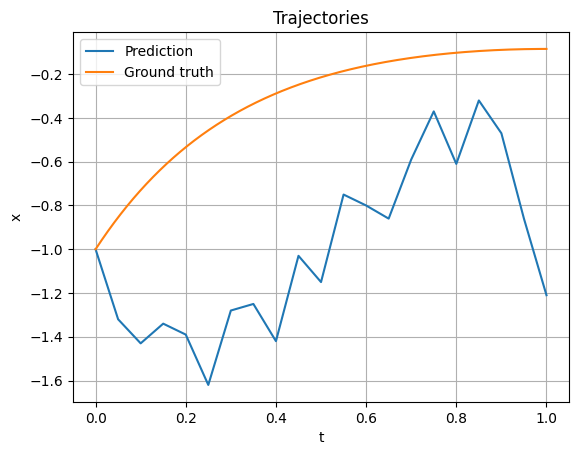

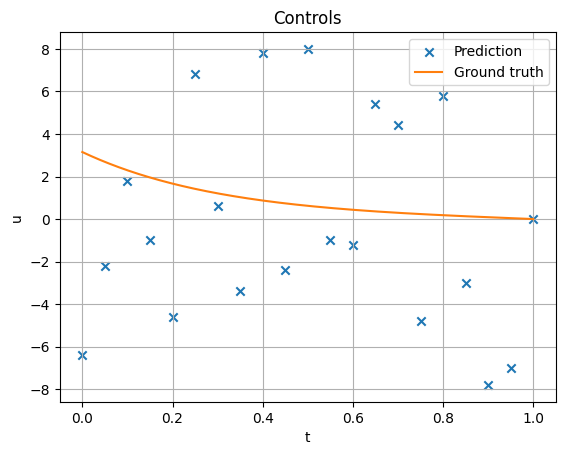

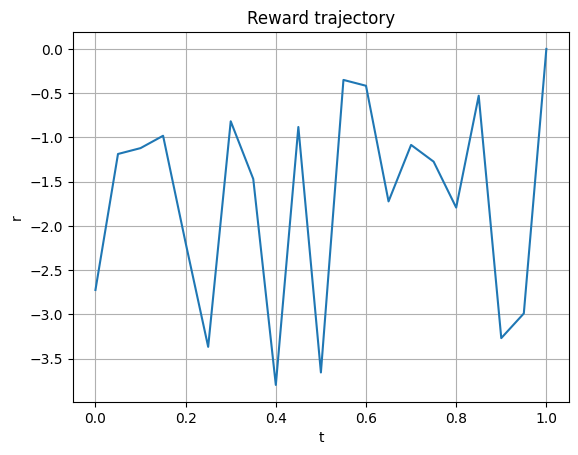

Cost for the predicted solution: 34.48463090578805
Optimal cost: 3.1509343154717495


In [17]:
x0 = -1
test_agent(agent)

$\to$ The predictions are not good, which is normal because Q is initialized randomly. In the following cell, we plot $Q$ at different time steps ($0$, $\frac{N}{2} T$ and $N-1$). Note that the $s$ dimension for $Q$ is very large because it needs to encompass all reachable states for our choice of $U_{\Delta u}^{RL}$, so we are here zooming on the part of interest, that is in the neighborhood of $[-1, 0]$.

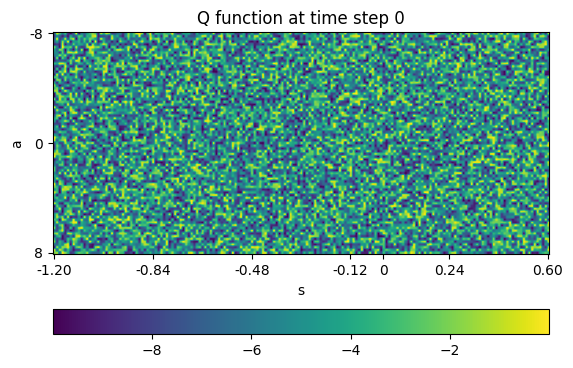

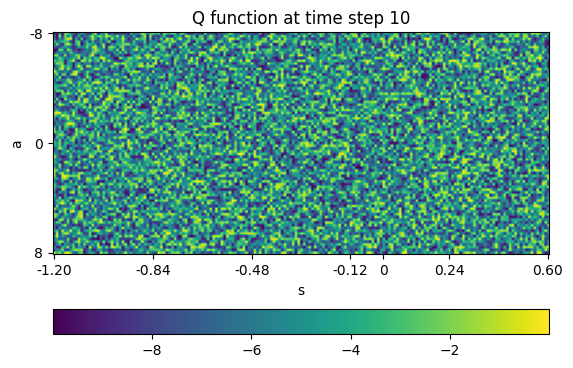

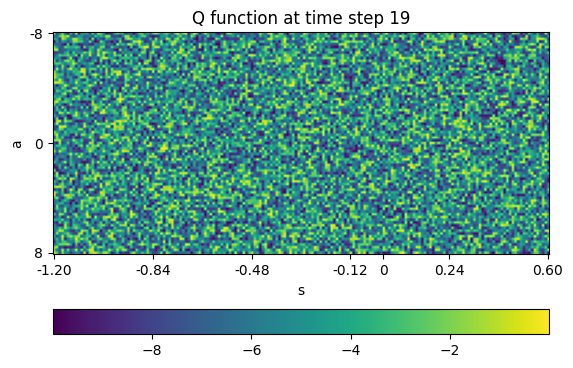

In [18]:
for n in [0, N//2, N-1]:
    plot_Q(agent.Q, n, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)))

##### Training the agent

In [ ]:
# This takes about 10min to run
agent.Q_learn(n_episodes=200000)

Predictions after training:

##### Results

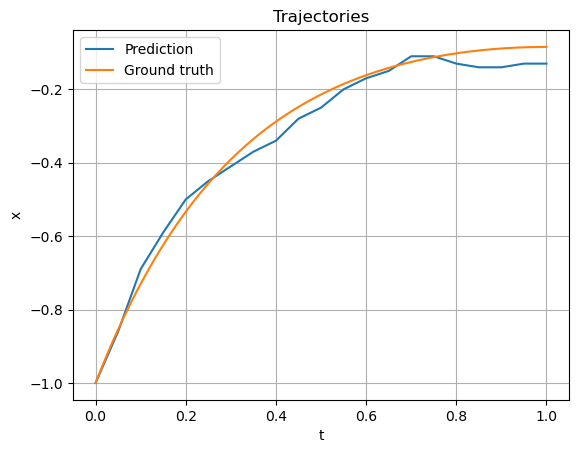

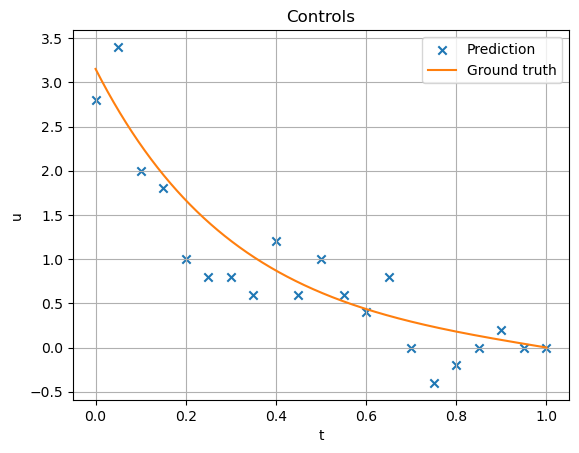

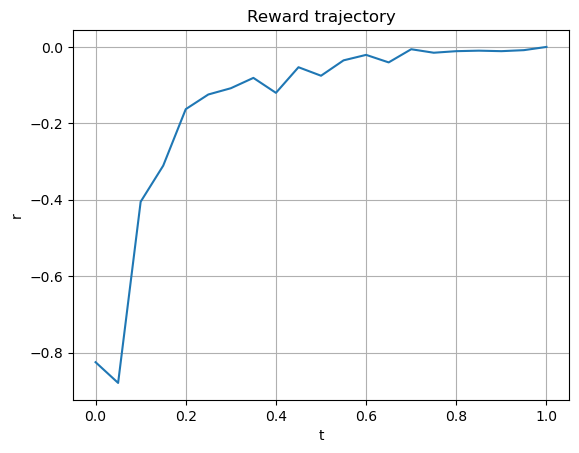

Cost for the predicted solution: 3.2245884815759194
Optimal cost: 3.1509343154717824


In [ ]:
test_agent(agent)

Much better! We see that the agent has learnt to solve the problem: the cost has gotten closer to the optimal and the predicted curves are closer to the ground truth. Still, it remains somewhat noisy.

Let's visualize this learning by plotting the $Q$ function again (here we cut values below $-5$, $-4$ and $-3$ and $-2$ at the respective time steps $0$, $\frac{N}{3}$, $\frac{2N}{3}$ and $N-1$ for better visualization, because rewards-to-go diminish as time goes) :

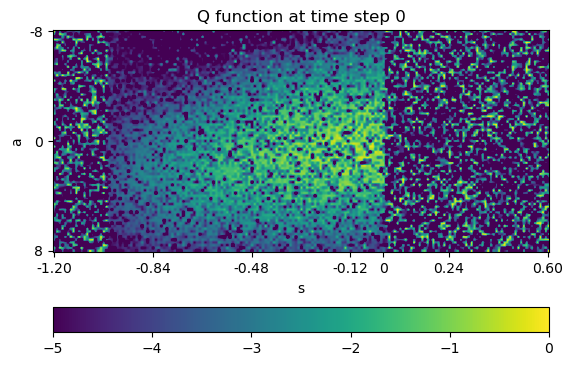

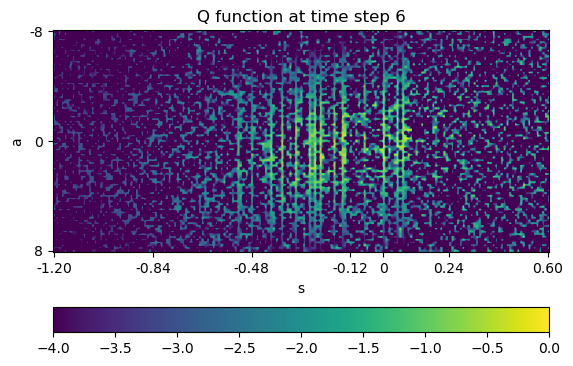

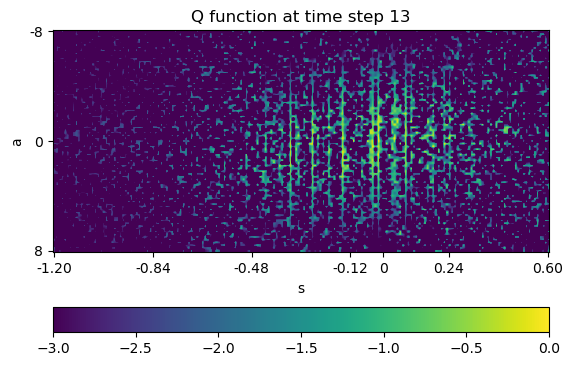

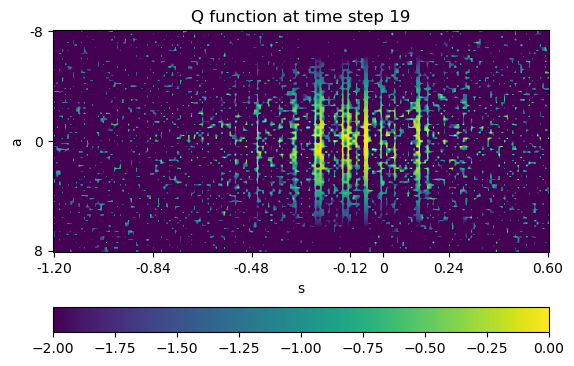

In [ ]:
plot_Q(agent.Q, 0, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-5, 0))
plot_Q(agent.Q, N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-4, 0))
plot_Q(agent.Q, 2*N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-3, 0))
plot_Q(agent.Q, N-1, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))

The $Q$ function is not random anymore! Let's make some observations.
 - At time $0$, the agent has fully explored states in $[-1, 0]$: this is normal, as it just corresponds to our initialization of $x_0$ durng training episodes.
 - As time goes, the explored area shifts towards the target because as it explores, the agent learns to get closer to the target, and thus explores these closer areas...
 - We also see that values closer to $a=0$ have higher values, which makes sense because stronger controls have higher costs and risk overshooting.
 - For later time steps, the explored areas tend to take the shape of thin vertical stripes (the later, the thinner). This is probably an effect of the $\epsilon$ term (main factor of exploration) not being high enough. My main hypothesis for that is that most of the exploration made by the agent comes from the random initial position. Now, assume the agent has already explored some trajectories with good evaluations, then the more you progress through an episode, the more likely you are to stumble upon one of these explroed paths; and from that point on you have less chance to diverge from that path because of a small $\varepsilon$. Hence on later time steps, the explored states are more sparse. Occasionally on these paths, randomness due to $\varepsilon$ will lead to testing new actions, which gives the vertical shape of these sparse explored states.
 - For early time steps, the values tend to be higher for higher actions, while $Q$ is more symetrical for later time steps. 

Finally, let's plot the evolution of the average cost and the average cumulative reward as the agent trains:

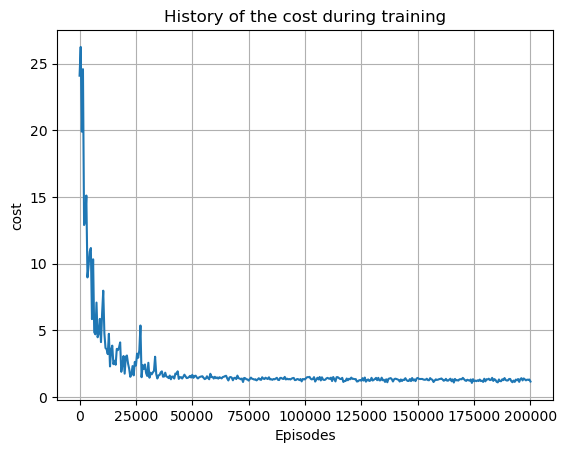

In [ ]:
plot_loss_history(agent.training_history.avg_cost, agent.training_history.evaluate_every, function_name="cost")

We observe that the average cost (for $x_0$ chosen uniformly in $[-1, 0]$) is decreasing and coverges to $\approx 1.2$.

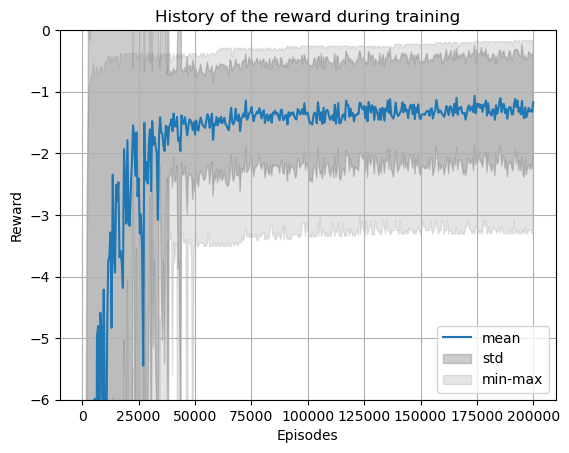

In [ ]:
plot_reward_history(agent.training_history.cumulative_rewards, agent.training_history.evaluate_every, crop_reward=(-6, 0))

Unsurprisingly, it is the symetrical of the previous because of the way we designed our reward. Here, we also see that the standard deviation decreases with time, but also that it steeply drops around 50000 episodes.

##### Testing different initial conditions

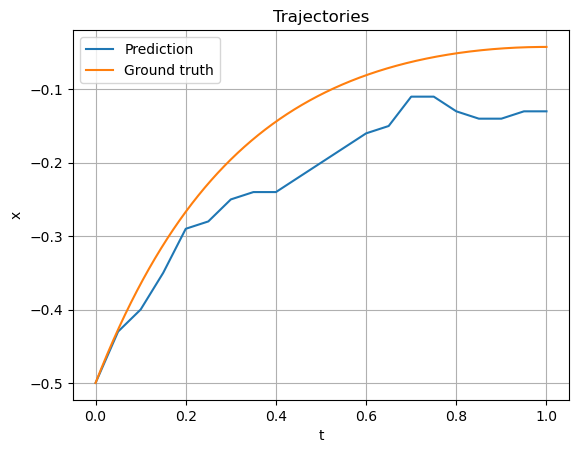

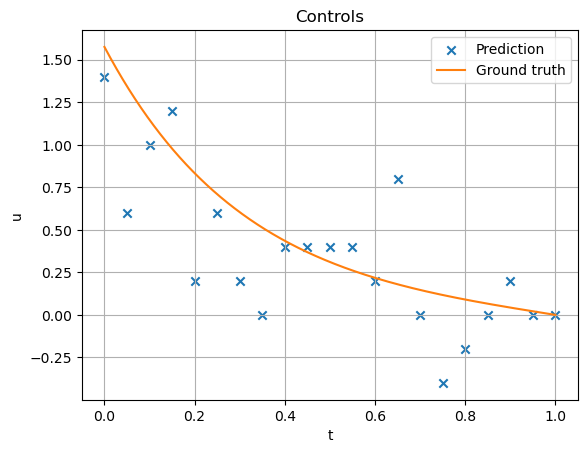

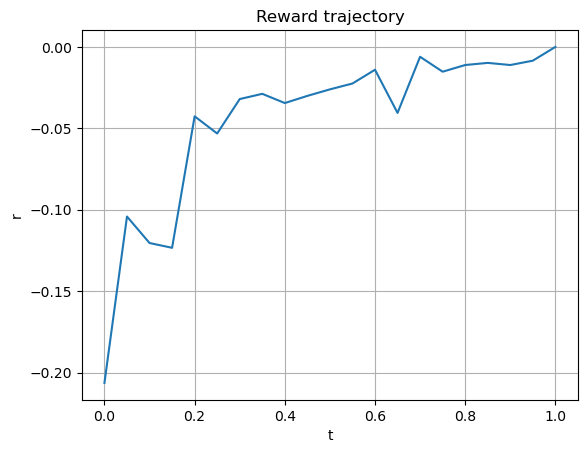

Cost for the predicted solution: 0.9240785598386743
Optimal cost: 0.7877335788679456


In [ ]:
x0 = -0.5
test_agent(agent, x0)

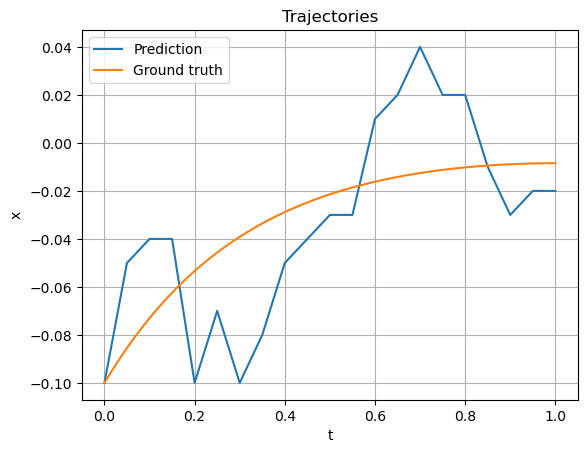

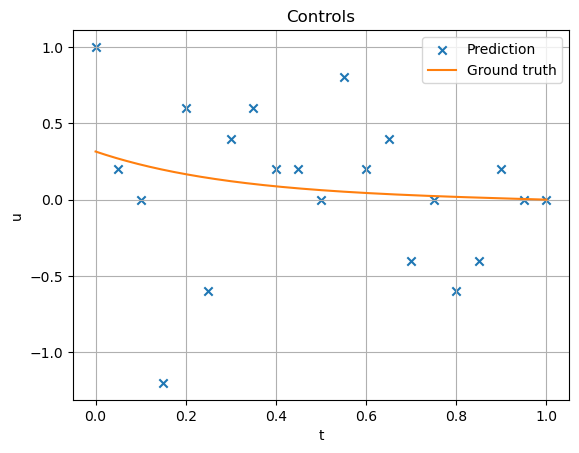

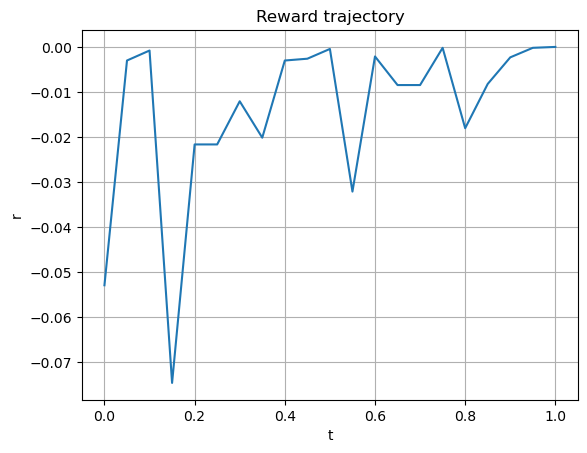

Cost for the predicted solution: 0.2801743809523807
Optimal cost: 0.03150650833590185


In [ ]:
x0 = -0.1
test_agent(agent, x0)

The agent seems not to be as good for smaller $x_0$, which might be an effect of the "vertical stripes" observed on $Q$ for later time steps, or it might be an effect of the precision on $u$...

### Twisting the parameters

#### Large $\varepsilon$

Let's choose a bigger $\varepsilon$ for the $\varepsilon$-policy: the exploration phase should be more pronouced, and the agent should have some difficulty converging, but might give better resuls.

In [ ]:
agent_eps = Agent(eps=0.85, lr=0.2)

In [ ]:
# This should take about 20min to train
agent_eps.Q_learn(n_episodes=400000)

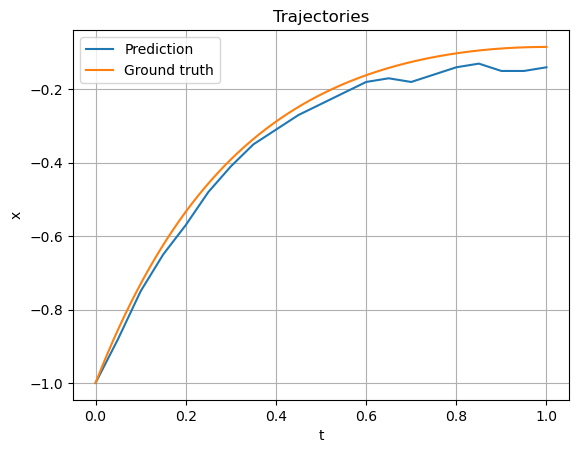

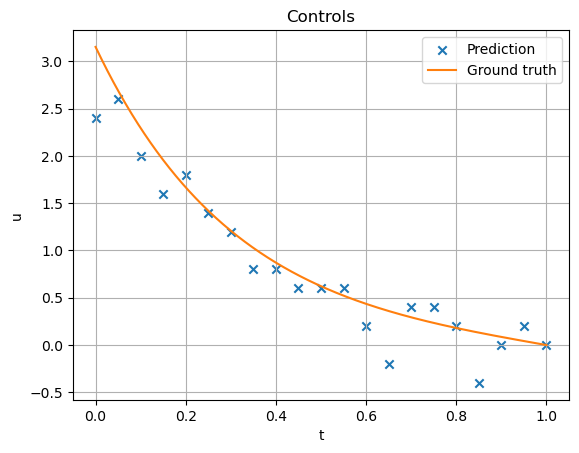

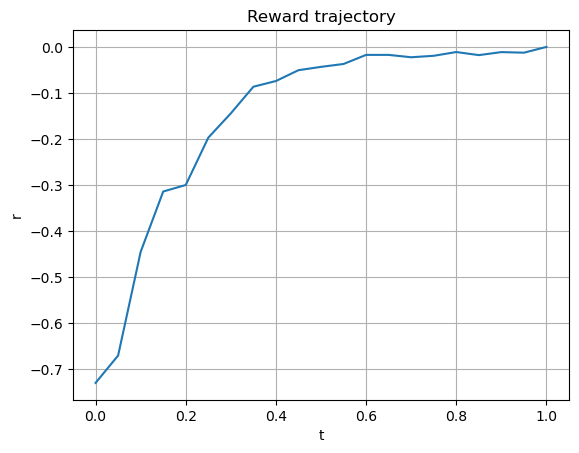

Cost for the predicted solution: 3.075512761904763
Optimal cost: 3.150650833590185


In [ ]:
test_agent(agent_eps)

The solution is much closer to the analytical solution! With more exploration, the agent has been able to discover more interesting paths, resulting in better overall results.
Also, note that since we don't use the same precision on the trajectory for the prediction and the ground truth, we also don't compute the cost with the same precision, so we might see costs that are "better" than the optimal. 

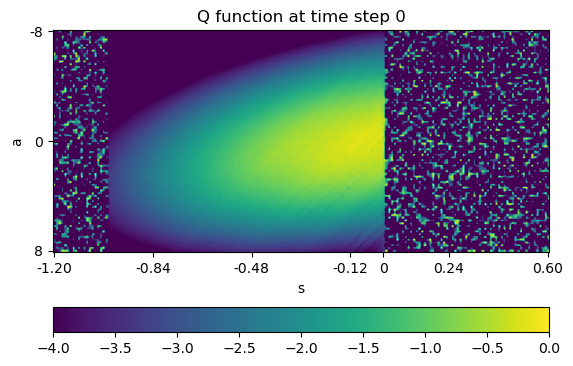

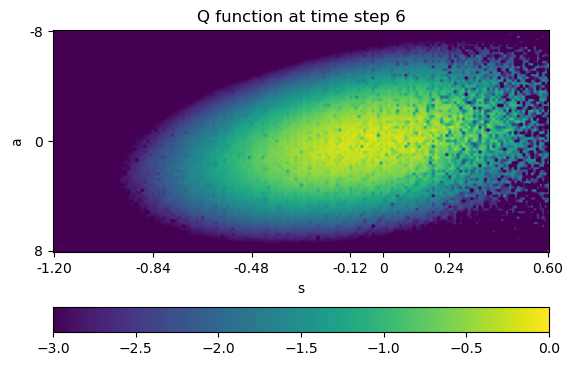

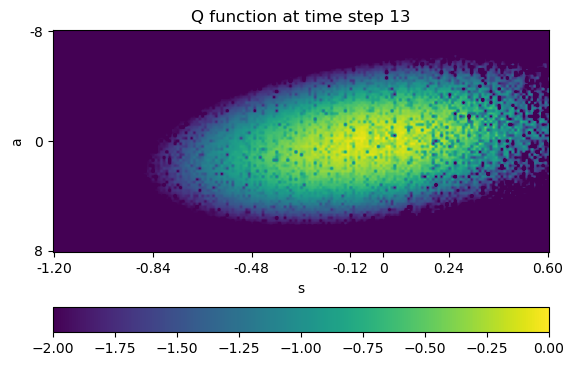

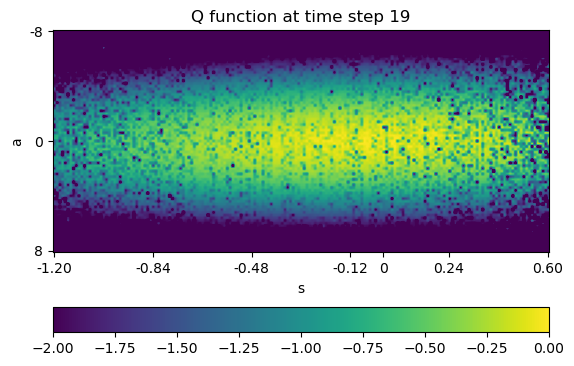

In [ ]:
plot_Q(agent_eps.Q, 0, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-4, 0))
plot_Q(agent_eps.Q, N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-3, 0))
plot_Q(agent_eps.Q, 2*N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))
plot_Q(agent_eps.Q, N-1, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))

The $Q$ function is much smoother and more largely explored, because the random decisions taken by the agent during the training allows the system to go almost anywhere at any time! Observations and interpretation is made easier here. We find again most of our previous observations. In particular, we see that the iso-$Q$ curves at a given time form ellipses that are tilted from bottom-left to top-right. This makes sense, because you rarely have any good reason to go left, unless you have overshot. This tilting tends to disappear in favour of a more symmetrical (w.r.t. $a$) $Q$-function for later time steps. This is probably because doing bad moves at the last moment has less incidence on the overall cumulative reward, because there are no further time steps to possibly chain bad moves thereafter.

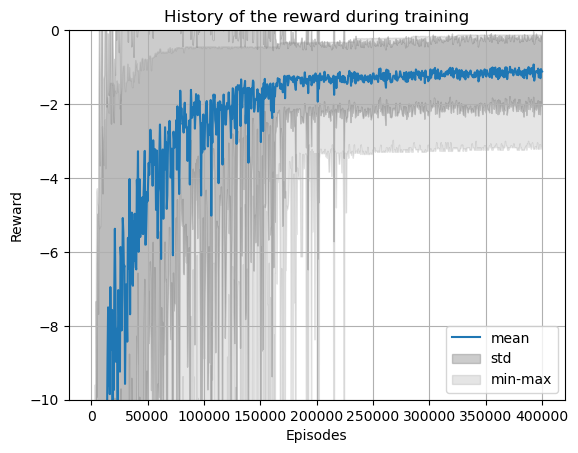

In [ ]:
plot_reward_history(agent_eps.training_history.cumulative_rewards, agent.training_history.evaluate_every, crop_reward=(-10, 0))

The agent took about four times as much time to converge. We still notice that the std drops steeply for some reason.

#### Testing different initial conditions

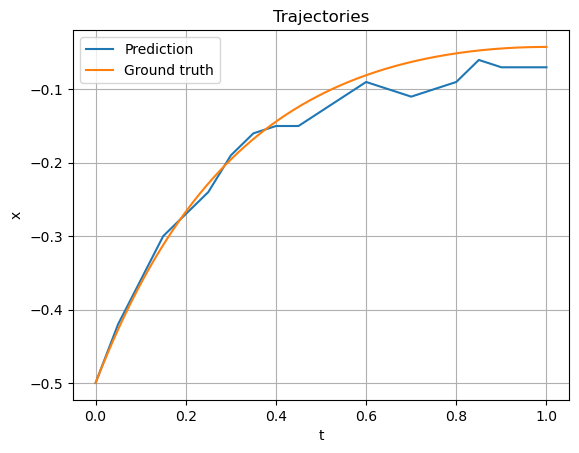

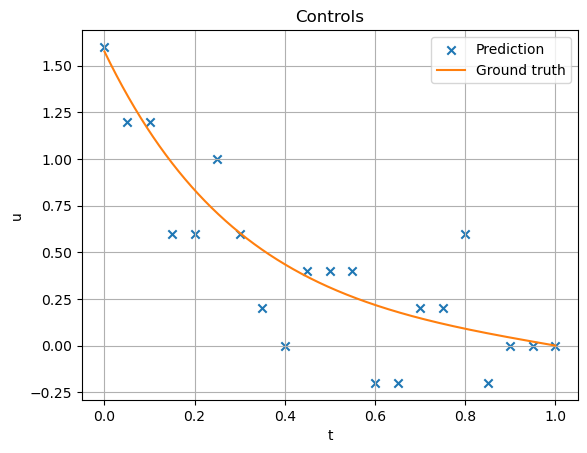

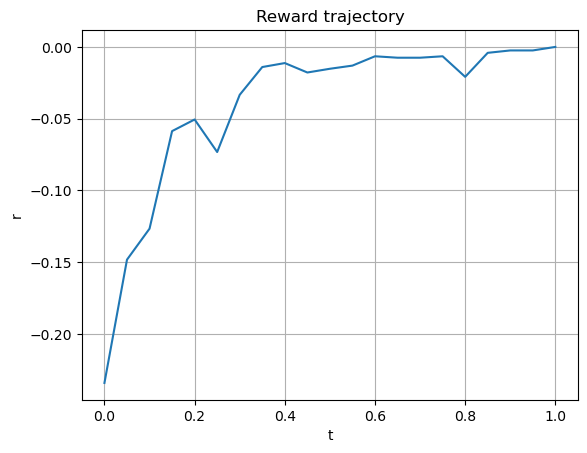

Cost for the predicted solution: 0.8150127619047616
Optimal cost: 0.7876627083975463


In [ ]:
x0 = -0.5
test_agent(agent_eps, x0)

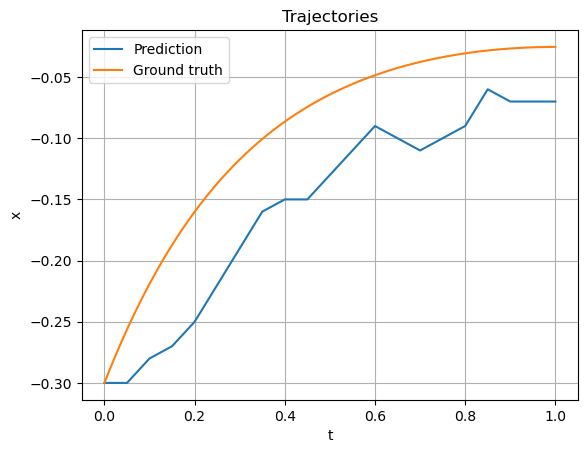

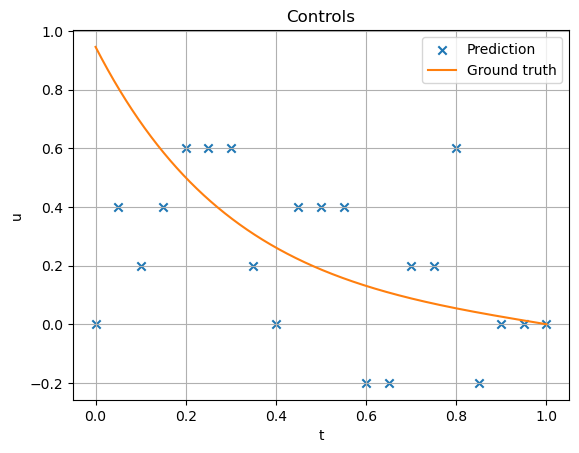

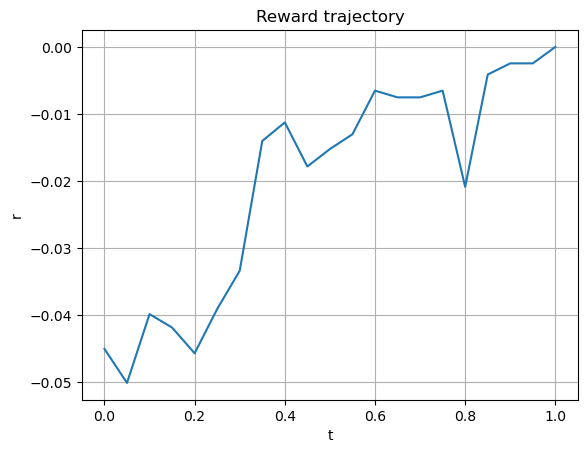

Cost for the predicted solution: 0.4043175238095232
Optimal cost: 0.2835585750231166


In [ ]:
x0 = -0.3
test_agent(agent_eps, x0)

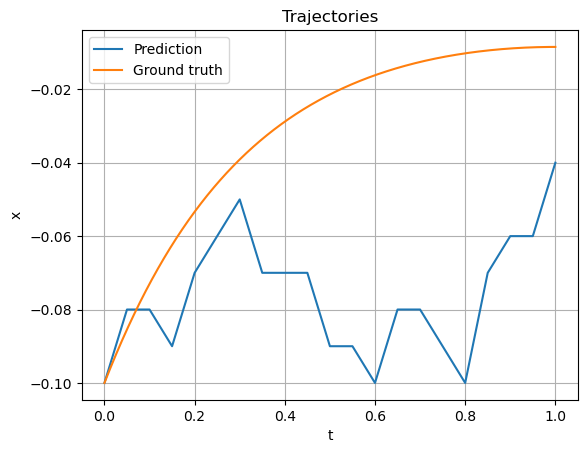

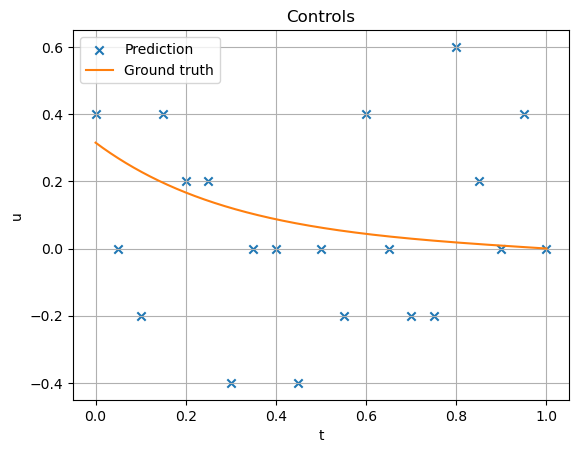

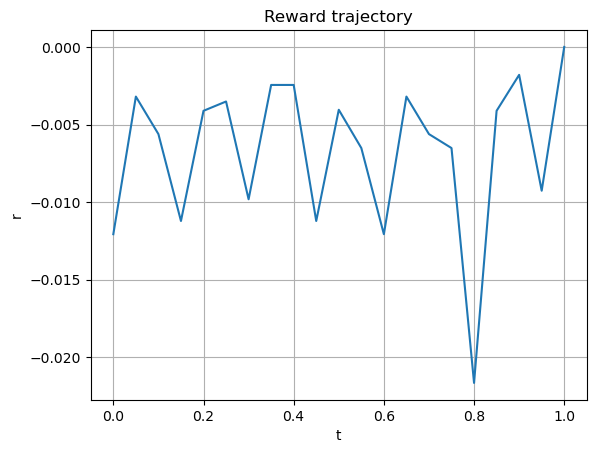

Cost for the predicted solution: 0.13408076190476195
Optimal cost: 0.03150650833590185


In [ ]:
x0 = -0.1
test_agent(agent_eps, x0)

#### Large learning rate

Finally, this time let's choose a bigger learning rate for the update of the $Q$ function. The learning procedure should converge faster, but might lead to results that are not as good.

In [64]:
agent_lr = Agent(eps=0.1, lr=1)

In [65]:
agent_lr.Q_learn(n_episodes=50000)

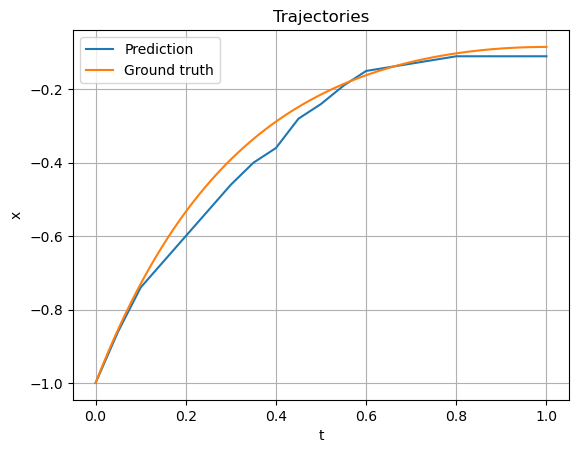

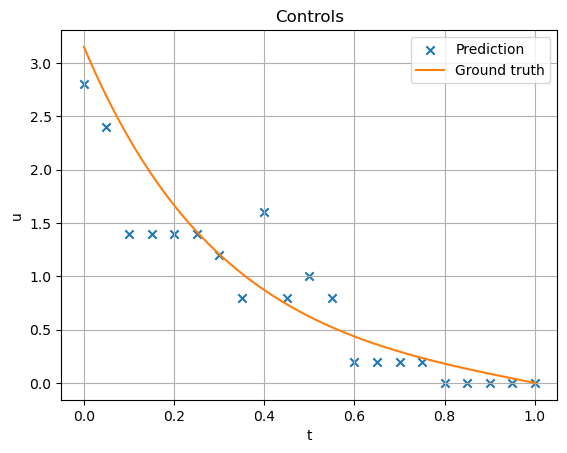

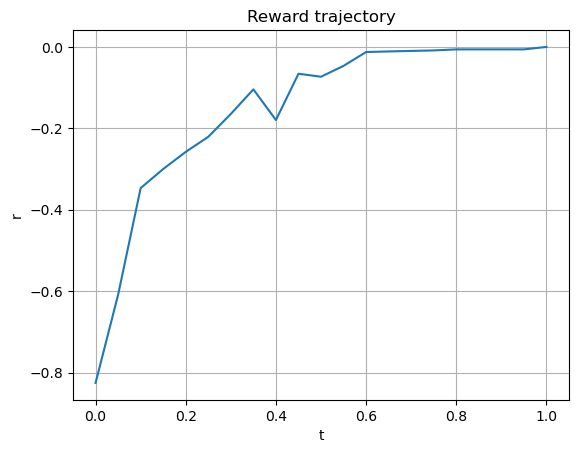

Cost for the predicted solution: 3.19128568124927
Optimal cost: 3.1509343154717824


In [66]:
test_agent(agent_lr)

Surprisingly, the agent still performed better that we our initial parameters.

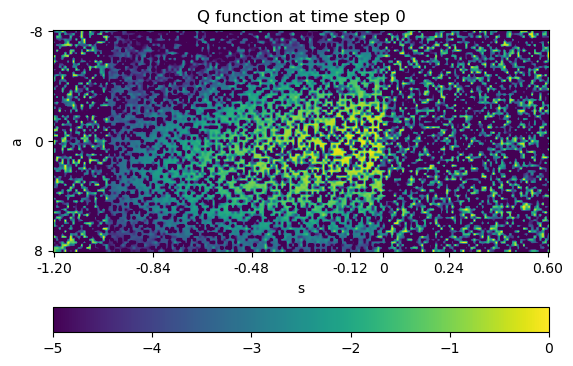

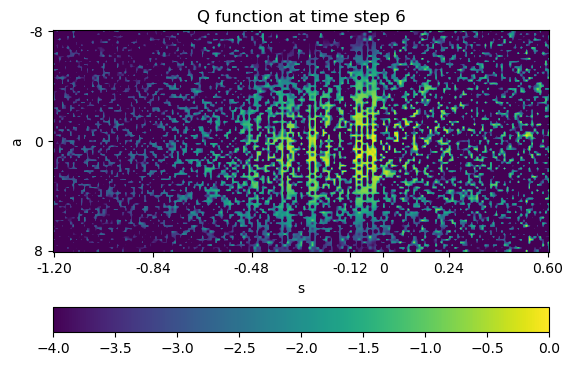

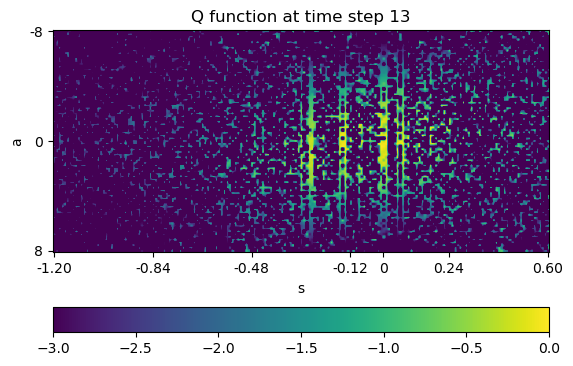

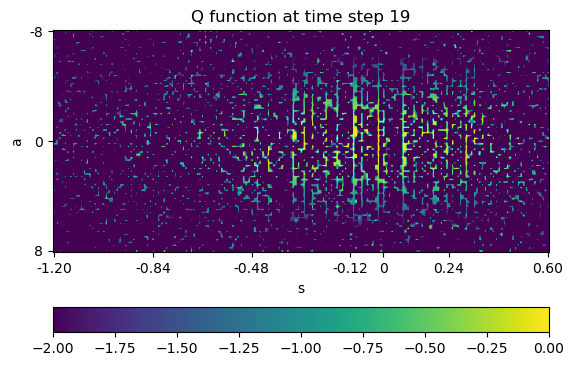

In [75]:
plot_Q(agent_lr.Q, 0, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-5, 0))
plot_Q(agent_lr.Q, N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-4, 0))
plot_Q(agent_lr.Q, 2*N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-3, 0))
plot_Q(agent_lr.Q, N-1, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))

We observe the same stripes as for the first agent.

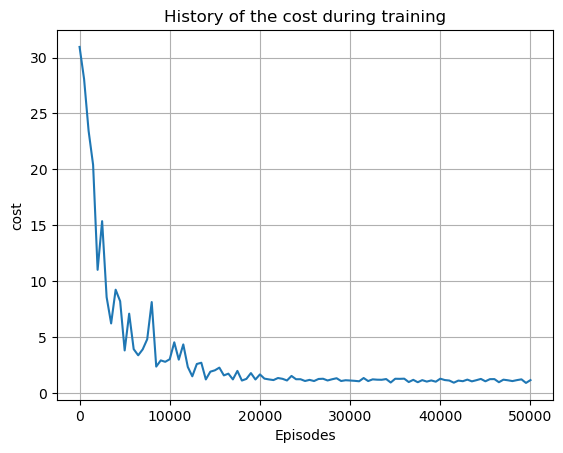

In [76]:
plot_loss_history(agent_lr.training_history.avg_cost, agent_lr.training_history.evaluate_every, function_name="cost")

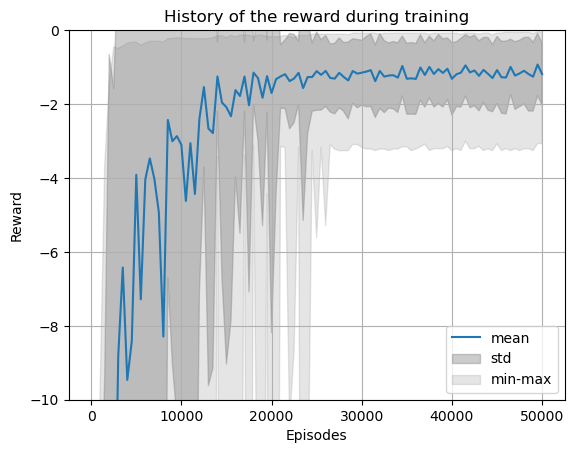

In [77]:
plot_reward_history(agent_lr.training_history.cumulative_rewards, agent_lr.training_history.evaluate_every, crop_reward=(-10, 0))

The agent converges about twice as fast as the first agent.

#### Testing different initial conditions

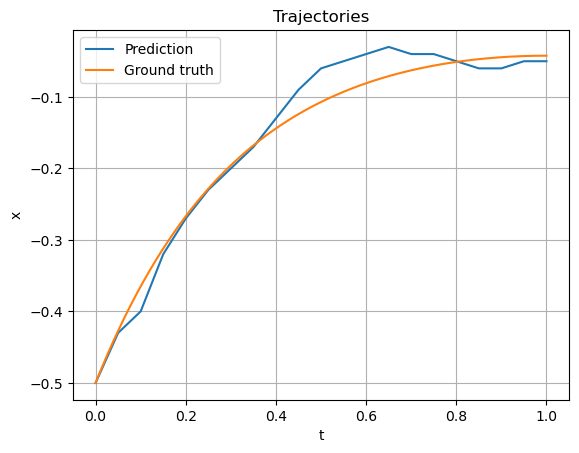

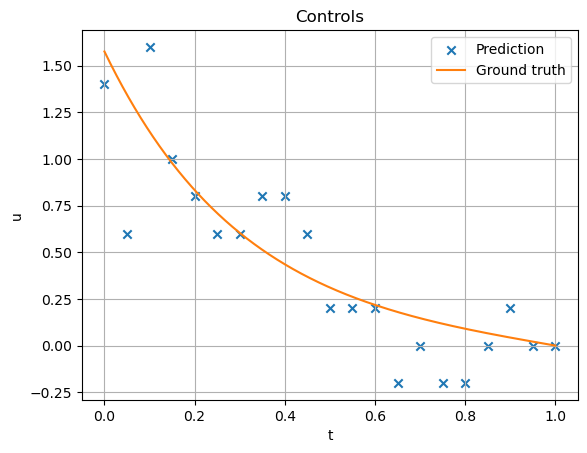

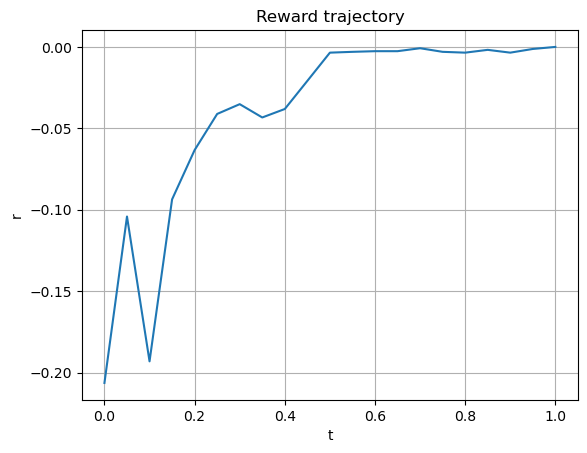

Cost for the predicted solution: 0.8428543318500741
Optimal cost: 0.7877335788679456


In [ ]:
x0 = -0.5
test_agent(agent_lr, x0)

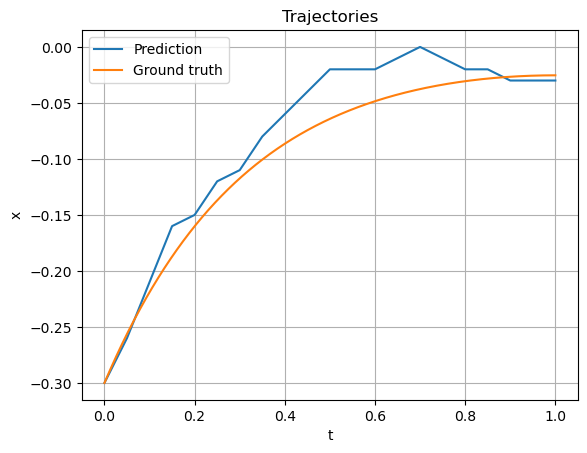

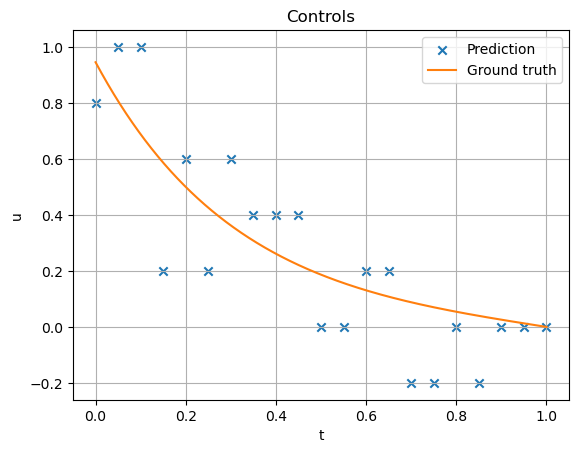

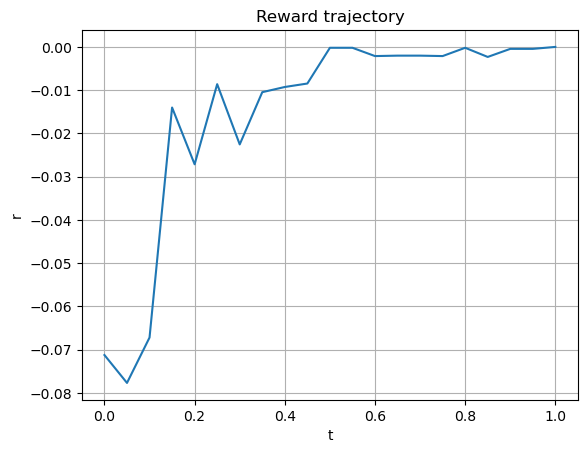

Cost for the predicted solution: 0.31393771428571404
Optimal cost: 0.2835585750231166


In [ ]:
x0 = -0.3
test_agent(agent_lr, x0)

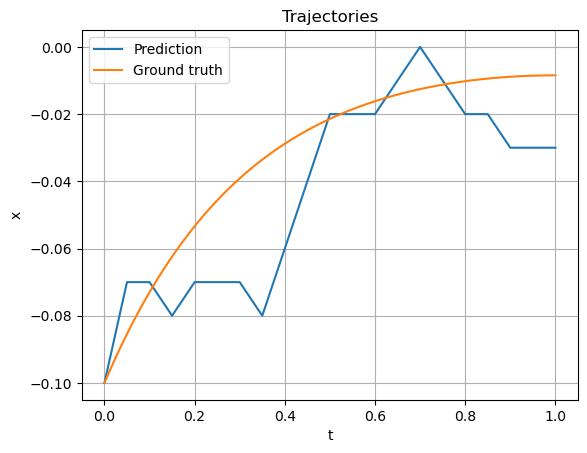

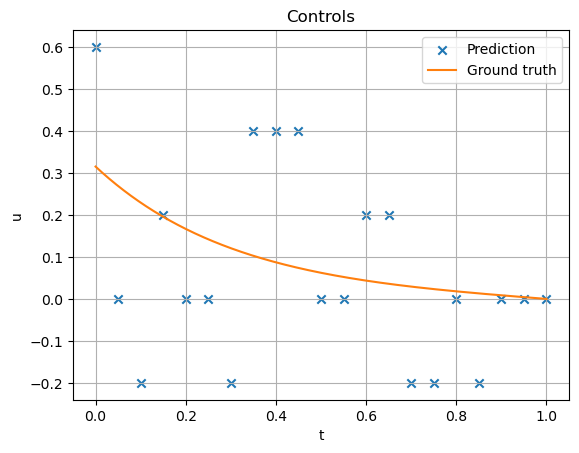

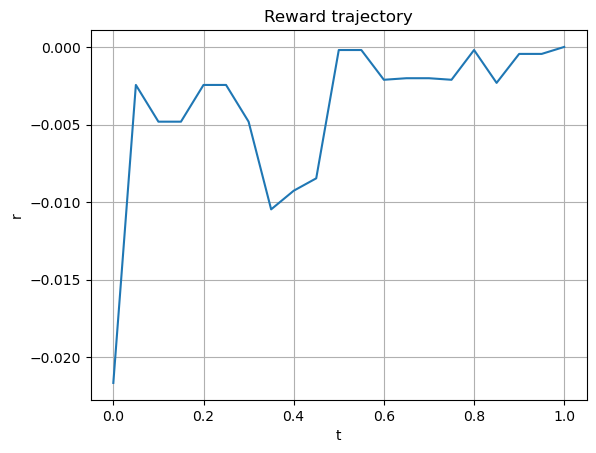

Cost for the predicted solution: 0.07997609523809526
Optimal cost: 0.03150650833590185


In [ ]:
x0 = -0.1
test_agent(agent_lr, x0)

#### Finding a compromise

We could look for optimized parameters in a systematic way, but here we have just tried different parameters by hand.

In [48]:
final_agent = Agent(eps=0.6, lr=1)

In [49]:
final_agent.Q_learn(n_episodes=100000)

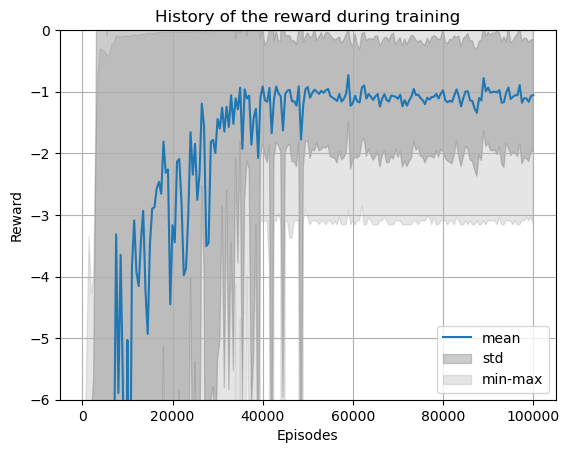

In [78]:
plot_reward_history(final_agent.training_history.cumulative_rewards, final_agent.training_history.evaluate_every, crop_reward=(-6, 0))

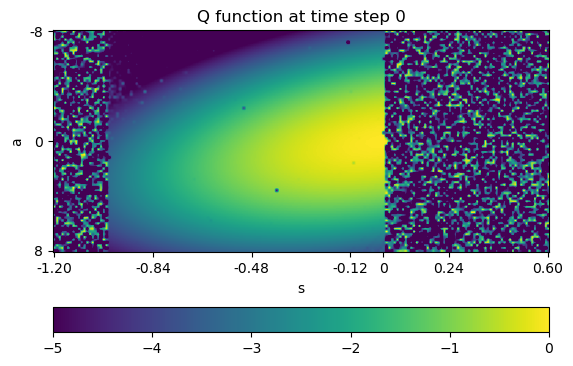

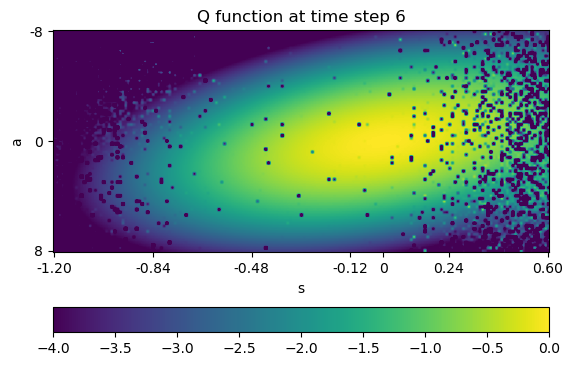

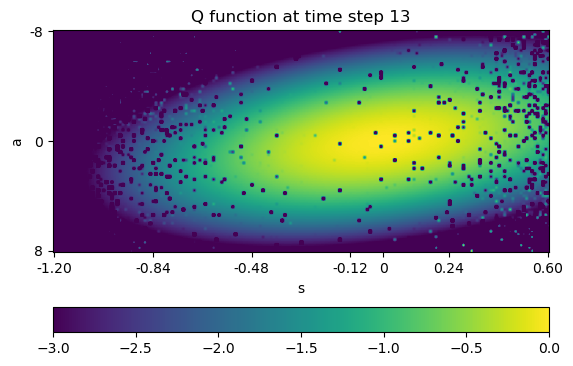

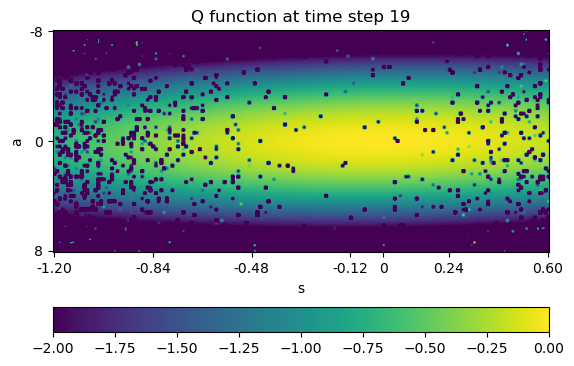

In [80]:
plot_Q(final_agent.Q, 0, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-5, 0))
plot_Q(final_agent.Q, N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-4, 0))
plot_Q(final_agent.Q, 2*N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-3, 0))
plot_Q(final_agent.Q, N-1, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))

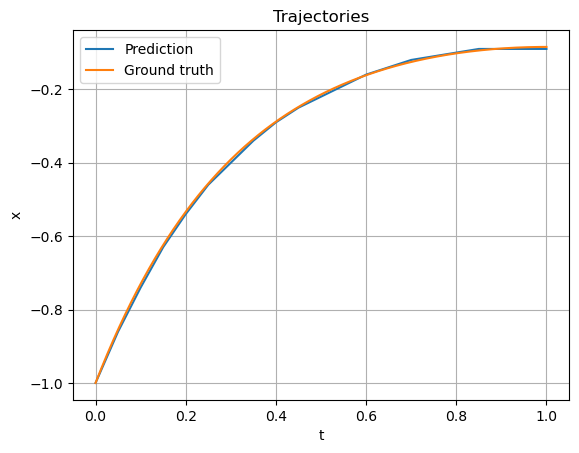

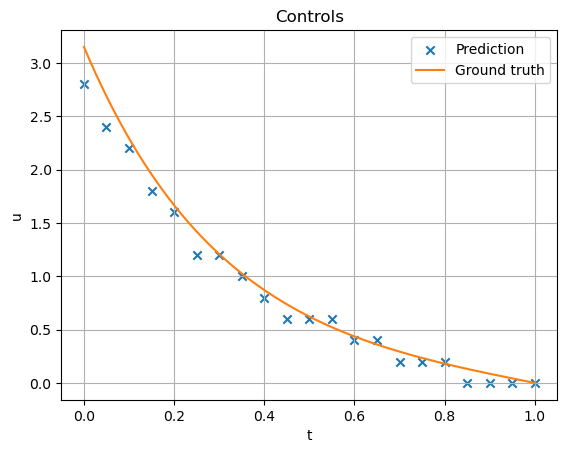

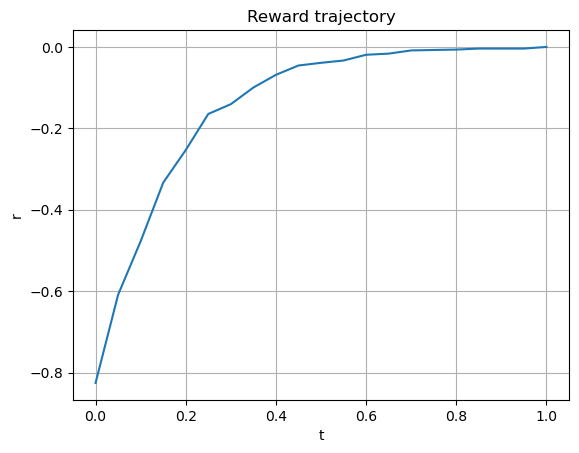

Cost for the predicted solution: 3.0875383849474187
Optimal cost: 3.1509343154717824


In [82]:
test_agent(final_agent, -1)

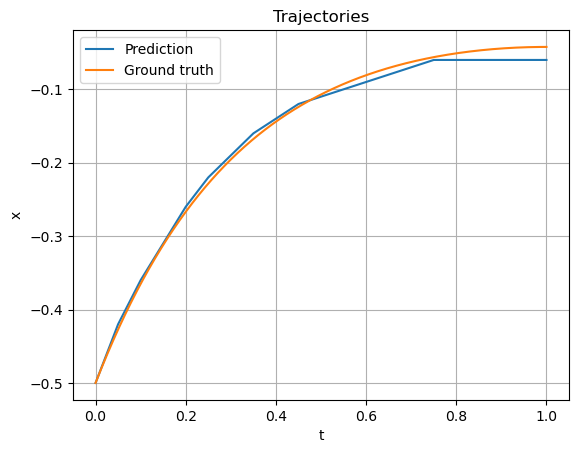

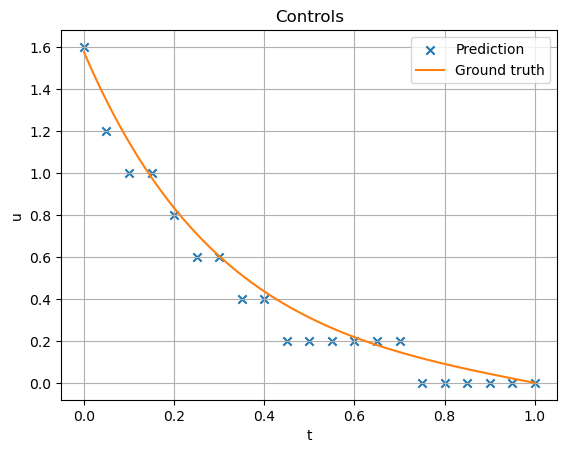

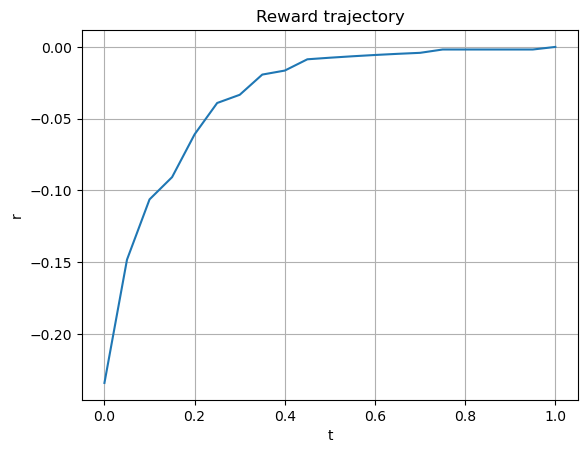

Cost for the predicted solution: 0.7755400809959507
Optimal cost: 0.7877335788679456


In [83]:
test_agent(final_agent, -0.5)

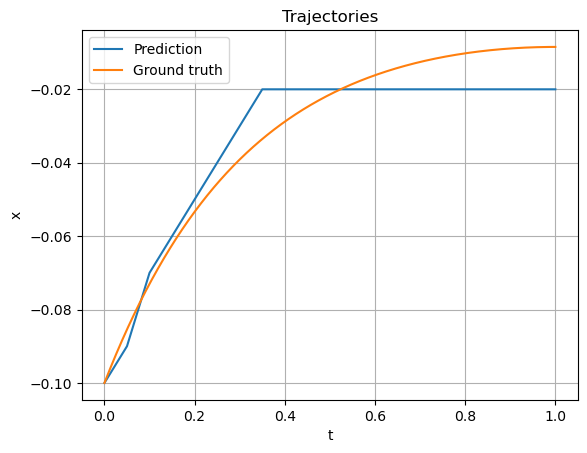

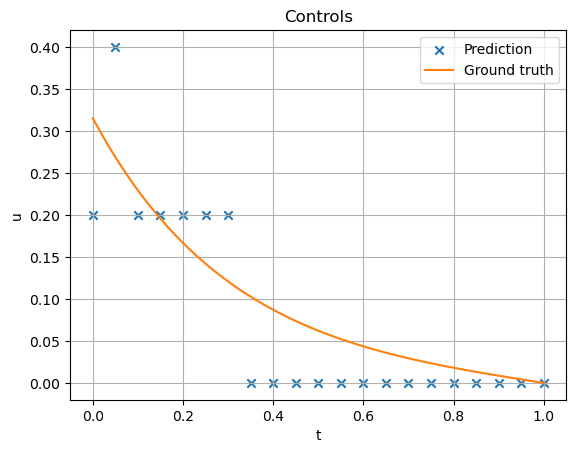

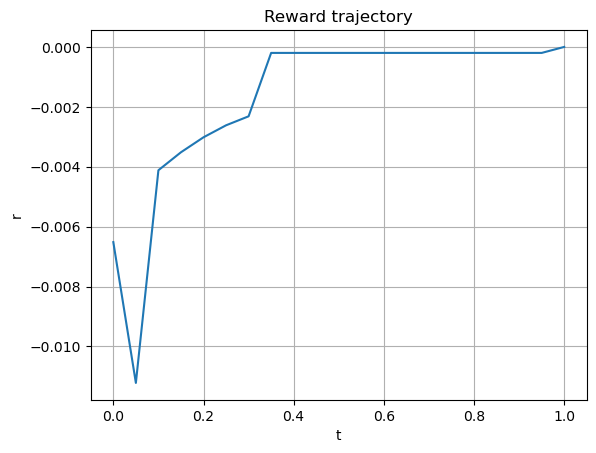

Cost for the predicted solution: 0.034961870873122955
Optimal cost: 0.031509343154717824


In [84]:
test_agent(final_agent, -0.1)

$\varepsilon=0.6$ and a learning rate of $1$ is already a satisfying compromise.

### Conclusion on vanilla Q-learning

We could still play with the parameters to try and get the best performance vs training-time compromise. For this simple deterministic problem, using both high learning rate and $\varepsilon$ seems to be ideal.

Let's make a comment on the sample efficiency here. If solved exactly with dynamic programming, our discretized problem would have a complexity of $\bigO(N\times|\Omega|\times|U|) = \bigO\big(N \times (\Omega_r - \Omega_l)N_{\Omega} \times (U_r - U_l)N_U\big)$. With our choice of parameters ($N=20$, $N_U=5$, $U_l=-8$ and $U_r=8$), this remains largely accessible as illustrated in the next section. Here it is actually more efficient in terms of data and time to resort to dynamic programming!

This illustrates that, although this RL method doesn't bother exploring all (state, action) pairs (as seen when looking at $Q$), it remains highly sample-inefficient. Many algorithms exist to try to make a better use of samples, for instance using deep reinforcement learning and replay buffers.

In the next section, we solve by DP to illustrate this.

## Dynamic programming

We have the following formulation in RL:
- state space: $S = \tilde{\Omega}_{\Delta x}^{RL}$; a state is $s \in S$ and is the position of the cart $\tf x$ at a given time step;
- action space: $A = \tilde{U}_{\Delta u}^{RL} $; an action is $a \in A$ and is a representation of the control $\tf u$ at a given time step;
- transition function: $f: S \times A \to S$ defined by $f(s, a) = \phi_{x \to x^{RL}}\Big(\P\big(\phi_{x^{RL} \to x}(s), \phi_{u^{RL} \to u}(a)\big)\Big)$
- running cost function: $\forall n \in \intset{0}{N-1}, \ c_n(s, a) \equiv c(s, a) = \lambda \Big( \Delta t |\phi_{x^{RL} \to x}(s)|^2 + {\Delta t}^2 \phi_{x^{RL} \to x}(s)\phi_{u^{RL} \to u}(a) + \frac{{\Delta t}^3}{3} |\phi_{u^{RL} \to u}(a)|^2 \Big) - \Delta t |\phi_{u^{RL} \to u}(a)|^2$
- final cost function: $c_N(s) = 0$

Here, $\forall s \in \tilde{\Omega}_{\Delta x}, \ V(N, s) = 0$ and the Bellman equation writes:
$$
    \forall n \in \intset{0}{N-1}, \ \forall s \in \tilde{\Omega}_{\Delta x}, \ V(n,x) = \min_{u \in \tilde{U}_\Delta u} \big(c(s, a) + V(n+1, \P(s, a)) \big)
$$

In [103]:
def  running_cost(sn, an):
    return LAMBDA*(DT*sn**2 + DT**2*sn*an + (DT**3)/3*an**2) + DT*an**2

def  final_cost(sN):
    return 0

def  transition_DP(sn, an):
    return x_to_x_RL(sn + DT*an)

def reachable_s(n):
    """ Set of positions that are reachable in n time steps. """
    return np.arange(-1 + n*Ul*DT, n*Ur*DT+Dx/2, Dx)

In [104]:
# Solve by DP
wt_0 = time.time()
action_space = np.arange(Ul, Ur+Du, Du)
V = np.inf*np.ones((N+1, (OMEGAr - OMEGAl)*N_OMEGA+1))
optimal_policy_array = np.ones((N, (OMEGAr - OMEGAl)*N_OMEGA+1))
for s in reachable_s(N):
    V[-1,x_to_x_RL(s)] = final_cost(s) 
for n in range(N-1, -1, -1):
    for s in reachable_s(n):
        costs = np.array([running_cost(s, a) for a in action_space])
        next_Vs = np.array([V[n+1, transition_DP(s, a)] for a in action_space])
        optimal_a = np.argmin(costs + next_Vs)
        V[n, x_to_x_RL(s)] = costs[optimal_a] + next_Vs[optimal_a]
        optimal_policy_array[n, x_to_x_RL(s)] = optimal_a
optimal_policy = lambda n,s: optimal_policy_array[n, s]
wt_1 = time.time()
print(f"Elapsed time: {wt_1 - wt_0}s")

Elapsed time: 5.752948999404907s


This only took a few seconds to run! Note that we are not exploring the entire state space here, but only those that are actually rechable at each time step starting in $[-1, 0]$ and using actions in $[-U_l, U_r]$. This further emphasizes the fact that the use of RL is not appropriate for such simple problems.

In [121]:
def plot_V(V, state_zoom=None, colorbar_limits=None, log_scale=False):
    state_zoom = state_zoom if state_zoom else (0, V.shape[1]-1)
    colorbar_limits = colorbar_limits if colorbar_limits else (None, None)
    truncated_V = V[:,state_zoom[0]:state_zoom[1]+1]
    plt.figure()
    if log_scale:
        plt.imshow(truncated_V, norm=LogNorm())
    else:
        plt.imshow(truncated_V, vmin=colorbar_limits[0], vmax=colorbar_limits[1])
    xticks = np.append(np.arange(0, truncated_V.shape[1], truncated_V.shape[1]//5), (x_to_x_RL(0)-state_zoom[0]))
    plt.xticks(ticks=xticks, labels=[f"{x:.2f}" for x in x_RL_to_x(np.arange(state_zoom[0], state_zoom[1]+1, truncated_V.shape[1]//5))]+[0])
    plt.colorbar(location="bottom")
    plt.title("Value function")
    plt.xlabel("x")
    plt.ylabel("n")
    plt.show()

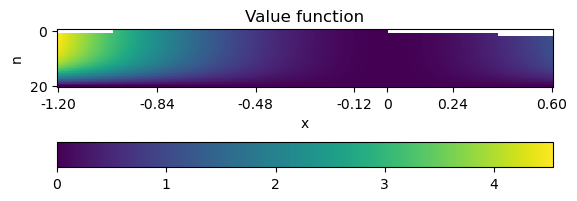

In [122]:
plot_V(V, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)))

In [123]:
def test_policy(policy, x0=-1):
    gt_x, gt_u = ground_truth_sample(x0, res=100000)
    predicted_x, predicted_u, reward_trajectory = simulator(x0, policy)
    plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)
    plot_control(predicted_u=predicted_u, gt_u=gt_u)
    plot_reward_trajectory(reward_trajectory)
    print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u, res_u=100000, res_mul_x=1000))
    print("Optimal cost:", cost(gt_x, gt_u))

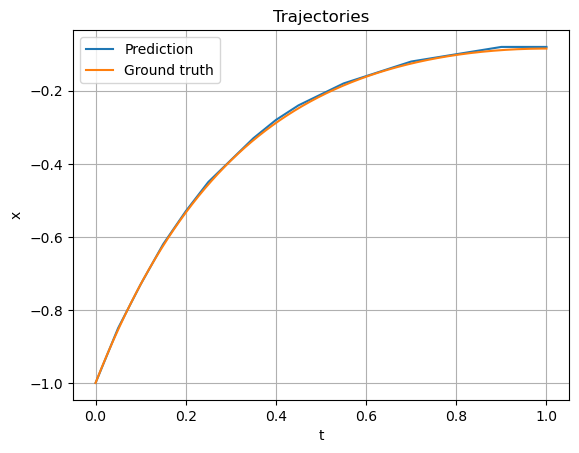

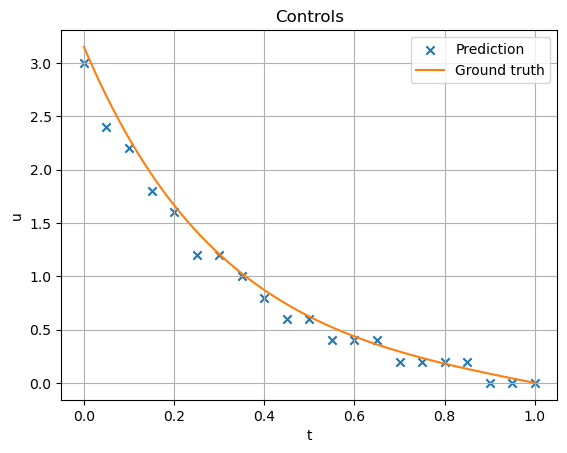

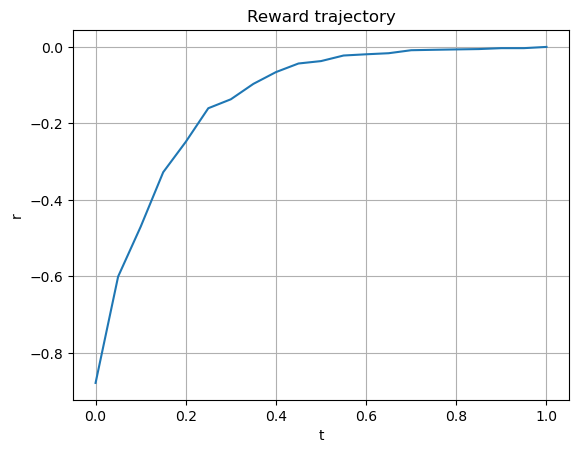

Cost for the predicted solution: 3.084158600653301
Optimal cost: 3.1509343154717824


In [124]:
test_policy(optimal_policy)

As expected, we get very good results; actually, as good results as we can get with this discretization.